In [ ]:
  %%capture
!pip install googletrans==3.1.0a0
!pip install transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# https://github.com/Kalit31/HASOC-2021/blob/main/English/BERT%20based/finetuned-bert.ipynb
# https://github.com/Kalit31/HASOC-2021

Mounted at /content/drive


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup



Load Data

In [ ]:
from pandas.core.api import unique
from six import unichr
filePath = '/content/drive/MyDrive/english_2021.csv'

import os
df = pd.read_csv(filePath,delimiter=',')
df = df.drop('task_2',axis=1)
df.columns = ['TwitterID','HASOCID','Text','Type']
df = df.drop(['TwitterID','HASOCID'],axis=1)

X = list(df['Text'].values)
Y_str = list(df['Type'].values)

d = dict([(y,x+1) for x,y in enumerate(sorted(set(Y_str)))])
# map Y to 0, 1 labels
Y=[d[x] - 1 for x in Y_str]
print(len(X))
print(len(Y))

3843
3843


In [ ]:
from googletrans.models import Translated
# https://colab.sandbox.google.com/drive/1PBC5TzaBsB9qq-12EWlxxR1TVlUQOllf?usp=sharing%E3%80%82#scrollTo=qa8p0H8O-Dzh
# show languages
#print(googletrans.LANGUAGES)
import random
# Create translation model
translator = Translator()
CMI = 0.00
#countOfWords = len("Geeksforgeeks is best Computer Science Portal")
translated_training_sentences = []
count = 0
for elem in X:
  elem_list = elem.split()
  countOfWords = len(elem_list)
  cmicount=round(0.00*countOfWords)
  indices = random.sample(range(countOfWords), cmicount)
  for i in indices: # we made an assumption here for simplicity
    translated_word = translator.translate(elem_list[i], src='en', dest='hi')
    if translated_word.pronunciation is not None:
      elem_list[i] = translated_word.pronunciation
  translated_sentence = ' '.join(elem_list)
  translated_training_sentences.append(translated_sentence)
  count += 1
  assert count == len(translated_training_sentences)

dfo = pd.DataFrame(translated_training_sentences, columns=['translate'])
file_name = '/content/drive/MyDrive/english_2021_translated_0p00.csv'
dfo.to_csv(file_name, sep=',')


Data Loading

In [ ]:
## Load the dataset into a pandas dataframe.
#df = pd.read_csv('√data/english/english_2021_translated_0p25.csv')
df = pd.read_csv('/content/drive/MyDrive/english_2021_translated_1p00.csv')
#df = pd.read_csv('/content/drive/MyDrive/english_2021.csv')
X = list(df['translate'].values)
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(len(X)))

# Train ~ 80%
# Validation ~ 10%
# Test = 10%

X_tmp, X_test, y_tmp, y_test = train_test_split(X, Y, test_size = 0.10, random_state=42,stratify=Y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tmp, y_tmp, test_size = 0.111, random_state=42,stratify=y_tmp)

print(len(X_train))
print(len(X_valid))
print(len(X_test))


Number of training sentences: 3,843

3074
384
385


In [ ]:
import torch
from transformers import XLMTokenizer, XLMWithLMHeadModel

! pip install sacremoses

def generate_dataset(X,y, tokenizer):

  #Generate encodings
  encodings = tokenizer.batch_encode_plus(X,
                                          truncation = True,
                                          padding=True,
                                          max_length=128,
                                          return_tensors='pt',
                                          add_special_tokens = True)

  #convert to tensor dataset
  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']

  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)
  y = torch.tensor(y)
  dataset = TensorDataset(input_ids,attention_mask,y)

  return dataset


model_name = 'xlm-mlm-100-1280'
#model_name = 'bert-base-uncased'
#model_name = 'bert-base-multilingual-cased' #  12-layer, 768-hidden, 12-heads, 110M parameters

 #mbert:
 #bert-base-multilingual-uncased: (Orig, not recommended) 102 languages, 12-layer, 768-hidden, 12-heads, 110M parameters #use this
#bert-base-multilingual-cased: (New, recommended) 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters

tokenizer = XLMTokenizer.from_pretrained(model_name)
model = XLMWithLMHeadModel.from_pretrained(model_name)
#tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
train_dataset = generate_dataset(X_train,y_train,tokenizer)
valid_dataset = generate_dataset(X_valid,y_valid,tokenizer)


# Print the original sentence.
print(' Original: ', X_train[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(X_train[0]))

# Print the tweet mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train[0])))


Some weights of XLMWithLMHeadModel were not initialized from the model checkpoint at xlm-mlm-100-1280 and are newly initialized: ['transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-b7c1d0ff789e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-13-b7c1d0ff789e>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


 Original:  @rosanalait @omminch yah avashy hona the pita, beta aur moot gadha ka sabhee teeke.
Tokenized:  ['@</w>', 'ro', 'san', 'al', 'ait</w>', '@</w>', 'om', 'min', 'ch</w>', 'yah</w>', 'av', 'ash', 'y</w>', 'h', 'ona</w>', 'the</w>', 'pita</w>', ',</w>', 'beta</w>', 'aur</w>', 'mo', 'ot</w>', 'gad', 'ha</w>', 'ka</w>', 'sab', 'hee</w>', 'te', 'eke</w>', '.</w>']
Token IDs:  [41428, 291, 2203, 226, 2376, 41428, 435, 1049, 472, 28300, 473, 4230, 38, 308, 1316, 17, 78128, 14, 39453, 23821, 973, 1129, 16743, 218, 156, 3906, 68121, 669, 11297, 15]


In [ ]:
def get_data_loader(dataset,sampler):
  return DataLoader(dataset=dataset,sampler=sampler(dataset),batch_size=32)

# random sampler for data
train_loader = get_data_loader(train_dataset,RandomSampler)
validation_loader = get_data_loader(valid_dataset,SequentialSampler)

Model Training

In [ ]:
from torch.cuda import is_available
import tensorflow as tf
device_name = tf.test.gpu_device_name()

import torch
print(torch.cuda.is_available())


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.cuda()
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-8)

num_epochs = 8
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


def compute_accuracy(preds,labels):
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels)/len(labels)


def train():
  total_loss = 0.0
  total_acc = 0.0

  model.train()

  num_steps = 0

  for step,batch in enumerate(train_loader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())

    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss/len(train_loader)
  avg_acc = total_acc/len(train_loader)

  return avg_loss,avg_acc

def evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()

  true_labels = []
  predictions = []

  for step,batch in enumerate(validation_loader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())

    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(validation_loader)
  avg_acc = total_acc/len(validation_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

You are using a model of type xlm to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


True


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing BertForSequenceClassification: ['transformer.layer_norm1.3.bias', 'transformer.attentions.13.v_lin.weight', 'transformer.ffns.8.lin2.weight', 'transformer.ffns.13.lin2.bias', 'transformer.ffns.12.lin2.weight', 'transformer.attentions.7.v_lin.bias', 'transformer.layer_norm2.12.bias', 'transformer.ffns.15.lin1.weight', 'transformer.attentions.0.k_lin.weight', 'transformer.attentions.6.out_lin.weight', 'transformer.attentions.6.q_lin.weight', 'transformer.layer_norm1.10.bias', 'transformer.layer_norm1.1.bias', 'transformer.attentions.14.k_lin.bias', 'transformer.attentions.9.q_lin.bias', 'transformer.ffns.13.lin2.weight', 'transformer.ffns.12.lin1.weight', 'transformer.attentions.14.q_lin.bias', 'transformer.attentions.6.v_lin.bias', 'transformer.ffns.9.lin2.bias', 'transformer.attentions.6.v_lin.weight', 'transformer.ffns.6.lin2.bias', 'transformer.attentions.13.v_lin.bias', 'transformer.attentions.1

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_f1 = 0.0

for epoch in range(num_epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))

  train_loss, train_acc = train()
  valid_loss, valid_acc,f1_score = evaluate()

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)

  if f1_score > best_f1:
      best_f1 = f1_score
      torch.save(model,'/content/drive/MyDrive/final_english_model_bert_8SeptAEM1.00Spt')


  print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:.3f} ')



 Epoch 1 / 8
  Batch    50  of     97.

Training Accuracy: 0.630 | Training Loss: 0.663 | Validation Accuracy: 0.659 | Validation Loss: 0.611 | F1 Score: 0.449 

 Epoch 2 / 8
  Batch    50  of     97.

Training Accuracy: 0.677 | Training Loss: 0.600 | Validation Accuracy: 0.667 | Validation Loss: 0.665 | F1 Score: 0.441 

 Epoch 3 / 8
  Batch    50  of     97.

Training Accuracy: 0.736 | Training Loss: 0.555 | Validation Accuracy: 0.745 | Validation Loss: 0.536 | F1 Score: 0.669 

 Epoch 4 / 8
  Batch    50  of     97.

Training Accuracy: 0.771 | Training Loss: 0.495 | Validation Accuracy: 0.773 | Validation Loss: 0.508 | F1 Score: 0.752 

 Epoch 5 / 8
  Batch    50  of     97.

Training Accuracy: 0.770 | Training Loss: 0.492 | Validation Accuracy: 0.622 | Validation Loss: 0.680 | F1 Score: 0.622 

 Epoch 6 / 8
  Batch    50  of     97.

Training Accuracy: 0.787 | Training Loss: 0.459 | Validation Accuracy: 0.729 | Validation Loss: 0.541 | F1 Score: 0.719 

 Epoch 7 / 8
  Batch    50 

Training/Validation Plots

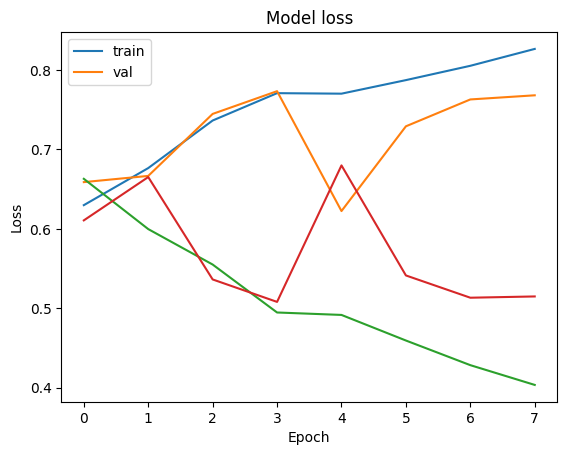

In [ ]:
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')


plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

Evals

In [ ]:

model = torch.load('/content/drive/MyDrive/final_english_model_bert_8SeptAEM1.00Spt')
model = model.to(device)


test_dataset = generate_dataset(X_test,y_test,tokenizer)
test_loader = get_data_loader(test_dataset,SequentialSampler)

def test_evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()

  true_labels = []
  predictions = []

  for step,batch in enumerate(test_loader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())

    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(test_loader)
  avg_acc = total_acc/len(test_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

test_loss,test_acc,f1_score = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f} ')


<ipython-input-13-b7c1d0ff789e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-13-b7c1d0ff789e>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)



Test Accuracy: 0.644 | Test Loss: 0.644 | F1 Score: 0.671 
